In [1]:
import os
import matplotlib.pyplot as plt 
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay



2025-07-17 11:11:02.507541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752750662.743369      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752750662.810365      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
base_dir = "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/"
subfolders = [
    "Train/WithMask", "Train/WithoutMask",
    "Validation/WithMask", "Validation/WithoutMask",
    "Test/WithMask", "Test/WithoutMask"
]

In [4]:
all_sizes = []

for subfolder in subfolders:
    folder_path = os.path.join(base_dir, subfolder)
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            try:
                img = Image.open(os.path.join(folder_path, filename))
                all_sizes.append(img.size)
            except:
                pass  


widths = [w for w, h in all_sizes]
heights = [h for w, h in all_sizes]


avg_width = int(np.mean(widths))
avg_height = int(np.mean(heights))


In [5]:
if avg_width >= 200 or avg_height >= 200:
    recommended_img_size = (224, 224)
elif avg_width >= 100 or avg_height >= 100:
    recommended_img_size = (128, 128)
else:
    recommended_img_size = (64, 64)


img_area = recommended_img_size[0] * recommended_img_size[1]
if img_area <= 64*64:
    recommended_batch = 64
elif img_area <= 128*128:
    recommended_batch = 32
else:
    recommended_batch = 16

print(" Recommended Image Size:", recommended_img_size)
print(" Recommended Batch Size:", recommended_batch)


 Recommended Image Size: (128, 128)
 Recommended Batch Size: 32


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "Train"),
    target_size=recommended_img_size,
    batch_size=recommended_batch,
    class_mode='categorical'
)

Found 10000 images belonging to 2 classes.


In [8]:
val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, "Validation"),
    target_size=recommended_img_size,
    batch_size=recommended_batch,
    class_mode='categorical'
)

Found 800 images belonging to 2 classes.


In [9]:
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, "Test"),
    target_size=recommended_img_size,
    batch_size=recommended_batch,
    class_mode='categorical',
    shuffle=False
)

Found 992 images belonging to 2 classes.


In [10]:
def generateModel(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
input_shape = (recommended_img_size[0], recommended_img_size[1], 3)
model = generateModel(input_shape)
model.summary()

I0000 00:00:1752750803.381775      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,110,466 (19.49 MB)

 Trainable params: 5,109,506 (19.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True)


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/25


I0000 00:00:1752750809.874804      79 service.cc:148] XLA service 0x7f9a9c004610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752750809.875823      79 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752750810.405386      79 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/313 ━━━━━━━━━━━━━━━━━━━━ 51:04 10s/step - accuracy: 0.6875 - loss: 1.7506

I0000 00:00:1752750814.935768      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 67s 183ms/step - accuracy: 0.8694 - loss: 1.0653 - val_accuracy: 0.6650 - val_loss: 1.1960 - learning_rate: 0.0010
Epoch 2/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 55s 177ms/step - accuracy: 0.9366 - loss: 0.2064 - val_accuracy: 0.9613 - val_loss: 0.1112 - learning_rate: 0.0010
Epoch 3/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 187ms/step - accuracy: 0.9504 - loss: 0.1554 - val_accuracy: 0.9438 - val_loss: 0.1591 - learning_rate: 0.0010
Epoch 4/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 169ms/step - accuracy: 0.9610 - loss: 0.1241 - val_accuracy: 0.9737 - val_loss: 0.0768 - learning_rate: 0.0010
Epoch 5/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 170ms/step - accuracy: 0.9633 - loss: 0.1135 - val_accuracy: 0.9875 - val_loss: 0.0469 - learning_rate: 0.0010
Epoch 6/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 55s 175ms/step - accuracy: 0.9651 - loss: 0.0992 - val_accuracy: 0.9550 - val_loss: 0.1651 - learning_rate: 0.0010
Epoch 7/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 170ms/step - accuracy: 0.9665 - loss:

In [13]:
model.load_weights("best_model.keras")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f" Final Test Accuracy: {test_accuracy:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.9968 - loss: 0.0161
 Final Test Accuracy: 0.9960


In [14]:
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
class_labels = list(test_generator.class_indices.keys())
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
Classification Report:

              precision    recall  f1-score   support

    WithMask       0.99      1.00      1.00       483
 WithoutMask       1.00      0.99      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



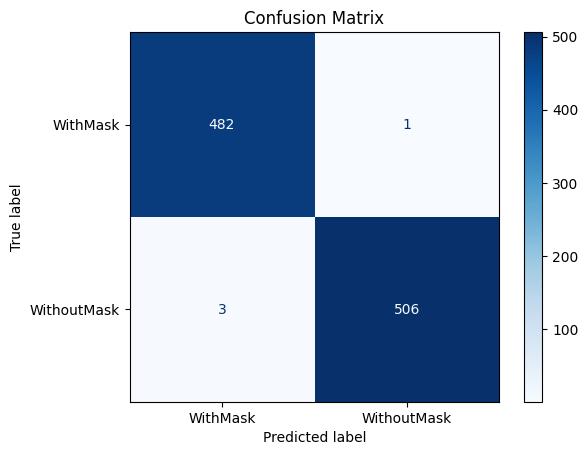

In [15]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [16]:
model.save("model.keras", save_format="keras")


In [17]:
from tensorflow.keras.models import load_model
model = load_model("model.keras")


In [18]:
from IPython.display import FileLink
FileLink('model.keras')

/kaggle/working/model.keras